In [174]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [175]:
def f(x):
    return x**2 + 2*x + 1

In [176]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

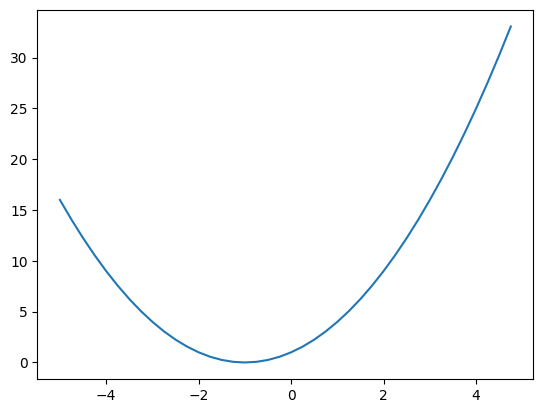

In [177]:
plt.plot(xs, ys)

If we want to find the derivative of this function w.r.t the different points on the curve, we use calculus

slope = (f(x+h) - f (x))/h

We can numerically check it by keeping h as a very small value say 0.0001, and then substituting x with any value on the curve. We can find the slope at that point analytically which would be approximately (as h is not zero but a very small value) equal to the slope at that point

A small example is shown below.

In [178]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a += h
d2 = a*b + c
print("Slope", (d2 - d1) / h) # this is w.r.t. a. Can change to b or c by adding h to them instead of a.

Slope -3.000000000010772


In [201]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # initialized to 0 as we assume that by default no node or weight affects the loss function. This is the derivative of loss function w.r.t. that node
        self._prev = set(_children) # this is used to keep track of the previous nodes in the graph
        self._backward = lambda: None  # this would be a function that would differ for all the different operators
        self._op = _op
        self.label = label
    
    def __repr__(self): # magic function to print the object. Can modify the string representation of the object when printed.
        return f"Value(data={self.data})"
    
    def __add__(self, other): # magic function to add two objects. Can modify the behavior of the + operator when applied to objects of this class. In case of a.__add__(b), a is self and b is other.
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data + other.data, (self, other), '+')
        def _backward(): # we want to take out grad and find out the self grad and other grad, so we will set self.grad to something and other.grad to something
            self.grad += 1.0 * out.grad # local derivative * global derivative
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
            
    def __mul__(self, other): # magic function to multiply two objects. Can modify the behavior of the * operator when applied to objects of this class. In case of a.__mul__(b), a is self and b is other.
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad # local derivative * global derivative
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
             self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __neg__(self): # -self
        return self * (-1)
    
    def __sub__(self, other): # self - other
        return self + (-other)
        
    def __truediv__(self, other): # self/other
        return self * (other ** -1)
        
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad # local derivative * global derivative
        out._backward = _backward
        return out
    
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0 # base condition
        for node in reversed(topo):
            node._backward()
        
  
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = f * d; L.label = 'L'
L
 # this is equivalent to (a.__mul__(b)).__add__(c)

Value(data=-8.0)

In [202]:
a = Value(10)
b = Value(20)
a-b

Value(data=-10)

In [144]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data:%.4f | grad:%.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

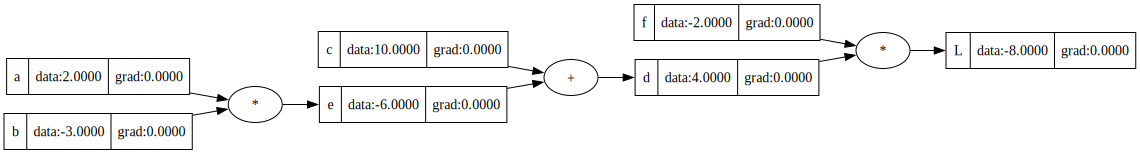

In [97]:
draw_dot(L)

This is the forward pass for this graph. Now we have to backpropagate. We will have to take derivative of L w.r.t. all nodes. Consider L is the loss function and all the nodes are weights of the neural network. We have to keep the weights so as to minimize the loss. Hence, we take derivative of all the loss function with respect to all weights. Consider a and b here as the inputs. We don't want to take derivatives w.r.t. a and b as they are fixed but other nodes (or weights) will be iterated upon with the information of the gradient.

In [60]:
# manually backpropagate
# L = f * d
# so, dL/dd = f, and dL/df = d. We can check these values numerically but adding h and dividing by h
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0


Now, we have to calculate dL/dc and dL/de. This is the main crux of backpropagation.\
By chain rule, dL/dc = dL/dd * dd/dc = (-2.0) * (1) (as d = e + c)\
Similarly, dL/de = dL/dd * dd/de = (-2.0) * (1)

In [61]:
c.grad = -2.0
e.grad = -2.0

Now, for dL/da and dL/db. Using chain rule we calculate them.\
dL/da = dl/de * de/da = (-2) * (-3) = 6.0\
dl/db = dl/de * de/db = (-2) * 2 = -4.0\
What are we doing here? We are multiplying local derivatives with the derivatives of the next layer that we have already calculated. This is the backpropagation. We keep on applying chain rule to the layers when going backwards.

In [62]:
a.grad = 6.0
b.grad = -4.0

Now for the leaf nodes (we usually have control over leaf nodes), we will check our claim. What is our claim? We claim that if we move in the direction of gradients, we will increase the value of the whole function.

In [63]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e + c
L = f * d
L

Value(data=-7.286496)

The value increased from -8 to -7.28 hence confirming our claim.

Now we will develop a neural network\
We will use tanh activation function\
tanh = (e^2x - 1)/(e^2x + 1)

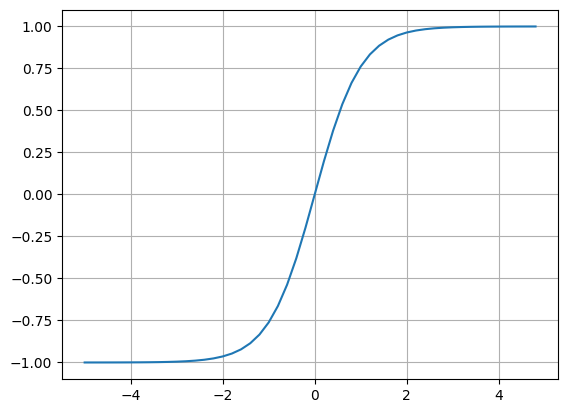

In [64]:
x = np.arange(-5, 5, 0.2)
plt.plot(x, np.tanh(x))
plt.grid()

In [162]:
# building a basic neuron
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# constant or bias
b = Value(6.8813735870195432, label='b') # just to get good numbers in output, setting this value
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

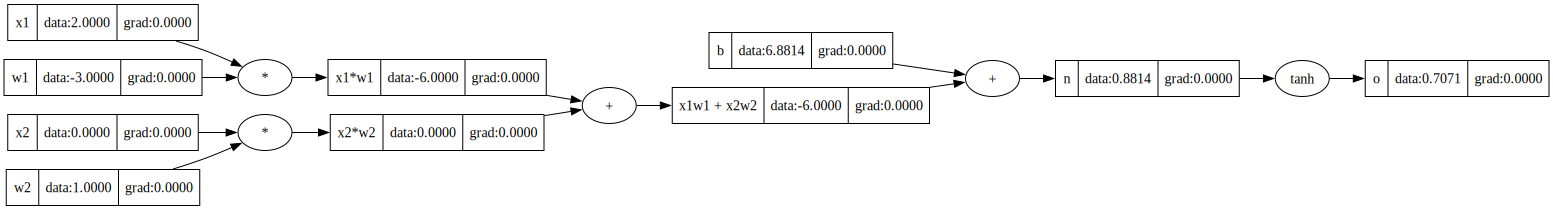

In [146]:
draw_dot(o)

In [ ]:
# manually setting gradients of this neuron
o.grad = 1

for do/dn, o = tanh(n)\
derivative of tanh(x) = 1 - tanh(x)** 2\
so, in our case, do/dn = 1 - tanh(n)** 2\
or, do/dn = 1 - o** 2

In [82]:
n.grad = 1 - o.data**2

In [86]:
n.grad = 0.5 # keeping the actual value instead of the approx value

In [93]:
# we get n by the addition, so the gradient of the both the adding units would be same as n i.e. 0.5
b.grad = 0.5
x1w1x2w2.grad = 0.5

# same for x1w1 and x2w2
x1w1.grad = 0.5
x2w2.grad = 0.5

# now for x1, w1, x2, and w2 by basic chain rule as do/dx1 = do/dx1w1 * dx1w1/dx1
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

Instead of doing it manually, we have created a _backward object in the Value class which is initialized to a blank function. For all the operations, we have defined a backward function which will be called to propagate the backpropagation for the gradients from output to that particular operator's input.

In [147]:
o.grad = 1 # have to set this manually as all the values are initialized to be 0 and this needs to be 1 for the starting of backpropagation
o._backward()  # this would set the gradient for n. The function backward for the object o was set during the forward pass for o = tanh(n). Hence, when we call this object, we would set the gradient value for n

In [151]:
n._backward()

In [152]:
x1w1x2w2._backward()

In [154]:
x1w1._backward()
x2w2._backward()

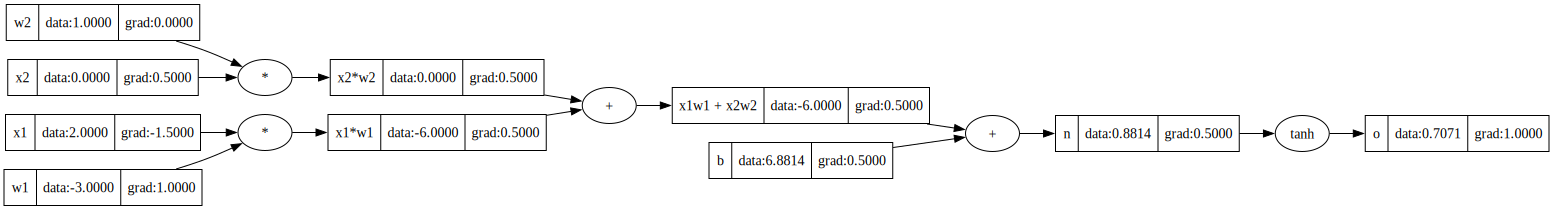

In [165]:
draw_dot(o)

For the backward propagation, we need to make sure that the gradients from the higher layer are already calculated and then we calculate the gradients of the current layer.
To make the process more robust for the backward propagation, we need to make sure that every backward call is made at the right order. For that we will do the topological sort

In [159]:
o.grad = 1.0 # base condition

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)

for node in reversed(topo): # for backward propagation
    node._backward()

In [137]:
for v in topo:
    print(v.label)

b
x2
w2
x2*w2
x1
w1
x1*w1
x1w1 + x2w2
n
o


In [164]:
o.backward()

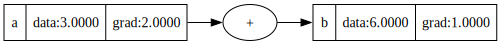

In [168]:
a = Value(3.0, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b)

In [205]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# constant or bias
b = Value(6.8813735870195432, label='b') # just to get good numbers in output, setting this value
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
e = (2 * n).exp()
o = (e - 1)/ (e + 1); o.label='o'


In [207]:
o.backward()

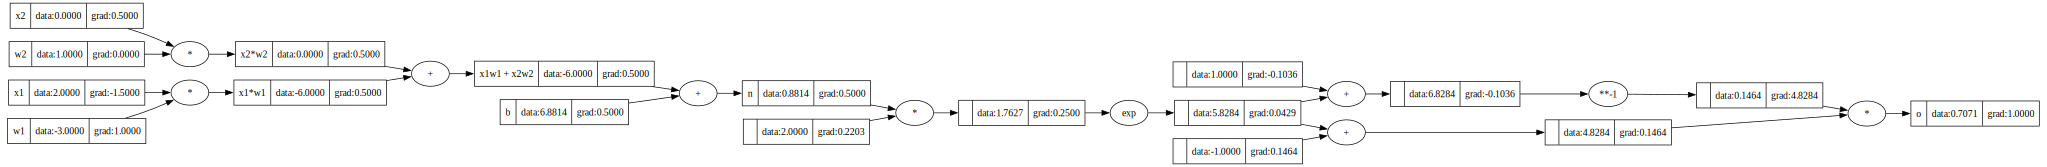

In [208]:
draw_dot(o)